# How to start working with spatial data in Python
This is a quick walk through implemented from a Jupyter notebook perspective (specifically, I'm working from the `jupyter/datascience-notebook:latest` Docker image. If you don't know what that means, you probably want to start with this tutorial on how to setup a Jupyter notebook with Python and Docker (link forthcoming). Alternatively, you may be working with Google Colab, in which case you may run into some dependency issues but you might be ok. This exercise starts with polygon data and then moves to point data.

### Setup
`Geopandas`(http://geopandas.org/) is the library of primary interest. It's is a wrapper for `shapely`, it depends on `fiona` for file access, and it uses `descartes` + `matplotlib` for plotting. `Fiona` itself relies on the massive open-source program GDAL/OGR.

Requirements: 
* Make sure that you have `geopandas` and `descartes` installed
* `pip install geopandas` and `pip install descartes`

In [1]:
# Setup
import pandas as pd
import numpy as np

import geopandas as gpd # This is what we're interested in
import matplotlib.pyplot as plt

# This is a cell magic that let's you display matplotlib plots inline
%matplotlib inline

## 1. Working with polygon data

### Obtaining data
We're going to start by acquiring a shapefile of the all the states in the United States from the Census TIGER shapefile warehouse. This is the main landing site: https://www.census.gov/geo/maps-data/data/tiger-line.html but let's use the shell command `wget` over FTP to obtain the data programmatically. You can call shell commands from Jupyter in a cell with the prefix `!`, so we type `!wget` to retrieve the file. You can also do this with other shell commands (try `!ls` or `!touch`).

Note: I'm using their FTP site to download the file but you can navigate your way through the GUI if you prefer.

In [2]:
# Get data with wget
!wget ftp://ftp2.census.gov/geo/tiger/TIGER2018/STATE/tl_2018_us_state.zip

--2019-03-14 20:28:15--  ftp://ftp2.census.gov/geo/tiger/TIGER2018/STATE/tl_2018_us_state.zip
           => ‘tl_2018_us_state.zip’
Resolving ftp2.census.gov (ftp2.census.gov)... 148.129.75.35, 2610:20:2010:a09:ffff:ffff:9481:4b23
Connecting to ftp2.census.gov (ftp2.census.gov)|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/tiger/TIGER2018/STATE ... done.
==> SIZE tl_2018_us_state.zip ... 9288777
==> PASV ... done.    ==> RETR tl_2018_us_state.zip ... done.
Length: 9288777 (8.9M) (unauthoritative)

tl_2018_us_state.zi 100%[===================>]   8.86M   495KB/s    in 18s     

2019-03-14 20:28:36 (503 KB/s) - ‘tl_2018_us_state.zip’ saved [9288777]



In [3]:
# Let's check to make sure the file is there
!ls -l

total 9424
-rw-r--r-- 1 jovyan users  150062 Mar 14 20:27 geospatial.ipynb
-rw-r--r-- 1 jovyan users 9288777 Mar 14 20:28 tl_2018_us_state.zip


### Load the shapefile as a geodataframe
Now that we have the data, we can load it as a geodataframe. First, unzip it, then load using the `read_file()` method.

In [4]:
# Unzip the file
!unzip tl_2018_us_state.zip

Archive:  tl_2018_us_state.zip
 extracting: tl_2018_us_state.cpg    
  inflating: tl_2018_us_state.dbf    
  inflating: tl_2018_us_state.prj    
  inflating: tl_2018_us_state.shp    
  inflating: tl_2018_us_state.shp.ea.iso.xml  
  inflating: tl_2018_us_state.shp.iso.xml  
  inflating: tl_2018_us_state.shx    


Shapefiles are actually a bunch of files. We want to load the `.shp` file speficially. `Geopandas` is smart enough to get the rest of the information it needs on its own.

In [5]:
# Load the data into a geodataframe
usa = gpd.read_file('tl_2018_us_state.shp')

### Plot the data
You can plot the data with the Pandas `plot()` function.

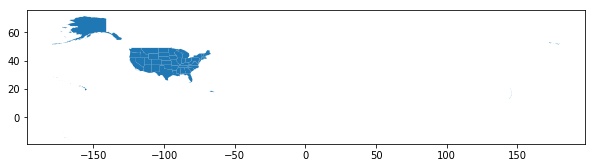

In [6]:
# Plot the data
usa.plot(figsize=(10,10))

This isn't the prettiest figure--there's something going on out past 150 degrees longitude (that would be Hawaii). If you want to restrict the plotting range, an easy way to do that is with the `plt.xlim` construct.

(20, 55)

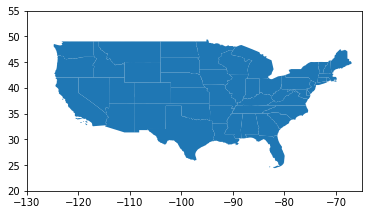

In [7]:
# Put some limits on your plot
usa.plot()

# Plot limits
plt.xlim([ -130, -65])
plt.ylim([20, 55])

### Quick note on dealing with coordinate reference systems and projections
A full explanation of coordinate reference systems is beyond the scope of this tutorial. Two points for now. 

(1) For now I will just say that if you're trying to do something like calculate the area of a polygon or the distance between two points, make sure you're using the right CRS. Remember how Greenland looks larger than Africa on some maps? That's because those maps are using a projection (like the Mercator) that distorts surface area. Use Mercator to sail across the Atlantic but not to calculate the area of Florida.

(2) You can change the CRS of your geodataframe using the `to_crs()` function. Example below.

In [8]:
# First, check the CRS of your object by inspecting the `crs` attribute
usa.crs

{'init': 'epsg:4269'}

`epsg:4269` is a SECRET CODE from the PETROLEUM GROUP that refers to a specific CRS, in this case the NAD83. You can read up on CRS 4269 and all the EPSG codes at https://epsg.io/4269

#### How to change the CRS
Let’s convert our USA dataframe into the US National Atlas Equal Area (https://epsg.io/2163).

In [9]:
# Change the CRS using the to_crs function
usa_projected = usa.to_crs(epsg=2163)

(-180, -55)

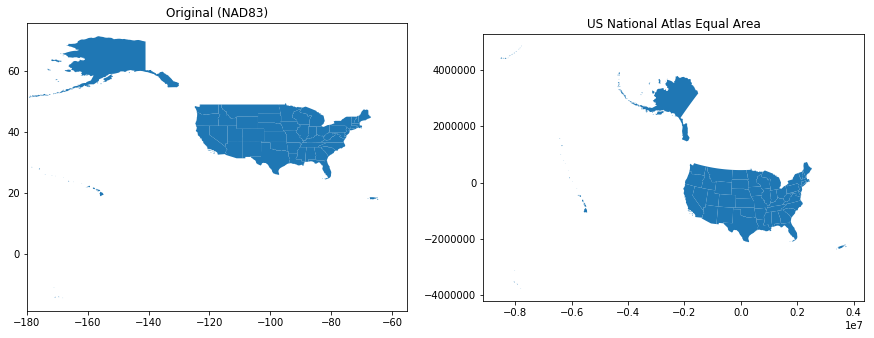

In [10]:
# Plot both geodataframes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

usa.plot(ax=ax1)
usa_projected.plot(ax=ax2)

# Label each figure
ax1.set_title('Original (NAD83)')
ax2.set_title('US National Atlas Equal Area')

# Set figure limits
ax1.set_xlim([-180,-55])

### Inspect the data
Moving on from the CRS discussion, let's talk about what you can do to a geodataframe.

In [11]:
# Inspect (some of) the data
usa[['NAME', 'ALAND', 'AWATER', 'geometry']].head(3)

,NAME,ALAND,AWATER,geometry
0,West Virginia,62266474513,489028543,"POLYGON ((-81.747254 39.095379, -81.746354 39...."
1,Florida,138949136250,31361101223,"(POLYGON ((-86.38864599999999 30.994181, -86.3..."
2,Illinois,143780567633,6214824948,"POLYGON ((-91.185295 40.637803, -91.1751 40.64..."


### Subsetting
Most of the things you can do to a dataframe you can also do to a geodataframe. One common task is subsetting the data. Let's say we just want to get a map of Florida. How do we do that? 

In [13]:
# First let's get a list of the first five state names
list(usa['NAME'][:5])

['West Virginia', 'Florida', 'Illinois', 'Minnesota', 'Maryland']

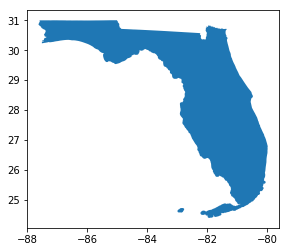

In [14]:
# Subset (note the use of the .loc construct)
florida = usa.loc[usa['NAME'] == 'Florida']

# Plot it
florida.plot()

## 2. Working with point data
Point data that comes in a geospatial data format is pretty easy to work with (do the same things as above). What's more tricky--and more common--is getting a CSV with lat/long pairs and then trying to turn that into a geodataframe. We'll start there. 

`Geopandas` doesn't understand a CSV with lat/long data columns, so we need to convert each line into a new `shapely` geometry, then feed that into a geodataframe. Let's go get some earthquake data from the USGS.

In [15]:
# Retrieve some point data
!wget https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_week.csv

--2019-03-14 20:30:33--  https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_week.csv
Resolving earthquake.usgs.gov (earthquake.usgs.gov)... 99.84.239.18, 99.84.239.75, 99.84.239.120, ...
Connecting to earthquake.usgs.gov (earthquake.usgs.gov)|99.84.239.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘all_week.csv’

all_week.csv            [  <=>               ] 322.57K   919KB/s    in 0.4s    

2019-03-14 20:30:34 (919 KB/s) - ‘all_week.csv’ saved [330309]



In [16]:
quakes = pd.read_csv('all_week.csv')

In [17]:
quakes.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2019-03-14T20:19:25.470Z,36.543499,-121.138000,8.26,1.54,md,6.0,140.0,NaN,0.02,...,2019-03-14T20:21:01.412Z,"1km NNE of Pinnacles, CA",earthquake,0.59,1.44,0.32,6.0,automatic,nc,nc
1,2019-03-14T20:18:03.340Z,37.958832,-122.118835,9.84,1.53,md,18.0,134.0,0.08216,0.03,...,2019-03-14T20:19:41.810Z,"5km SW of Pacheco, CA",earthquake,0.34,0.50,0.09,13.0,automatic,nc,nc


In [18]:
# First we need to load two handy functions
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [19]:
# Turn the permit data into a geodataframe 

# Use the Point function to turn each lat/long pair into a shapely geometry object
geometry = [Point(xy) for xy in zip(quakes.longitude, quakes.latitude)]

# Create a new object that is the old dataframe minus the lat/long columns
quakes_gdf = quakes.drop(['longitude', 'latitude'], axis=1)

# Define the CRS
crs = {'init': 'epsg:2163'}

# Turn the new object into a geodataframe using the GeoDataFrame function
quakes_gdf = GeoDataFrame(quakes_gdf, crs=crs, geometry=geometry)

Let's take a look at the `geometry` attribute

In [20]:
# What does it look like?
quakes_gdf[['time', 'depth', 'mag', 'geometry']].head(3)

,time,depth,mag,geometry
0,2019-03-14T20:19:25.470Z,8.26,1.54,POINT (-121.1380005 36.543499)
1,2019-03-14T20:18:03.340Z,9.84,1.53,POINT (-122.1188354 37.9588318)
2,2019-03-14T20:08:48.716Z,7.50,2.40,POINT (-151.0654 60.9103)


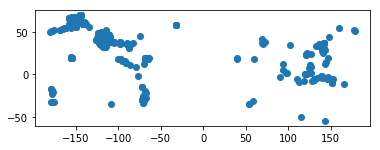

In [21]:
# Plot it
quakes_gdf.plot()

(-20, 80)

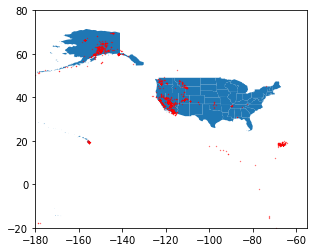

In [22]:
# Plot it on top of the USA shapefile
fig, ax = plt.subplots()

usa.plot(ax=ax)
quakes_gdf.plot(ax=ax, alpha=0.8, color='red', markersize=0.1)

plt.xlim([-180, -55])
plt.ylim([-20, 80])